In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image, ExifTags
import albumentations as A

##### Данные к df

In [4]:
def create_df(file_txt: str) -> pd.DataFrame:
    """Create_df_for_EDA"""
    with open(file_txt) as json_data:
        data = json.load(json_data)
        df = pd.DataFrame(
            [path_image for path_images in data.values() for path_image in path_images], 
            columns=['paths']
        )
        
        df['labels'] = df['paths'].apply(lambda x: x.split('/')[0])
        
        return df

In [5]:
df_train = create_df("meta/train.json")

In [6]:
df_train.sample()

,paths,labels
67206,huevos_rancheros/3104263,huevos_rancheros


In [7]:
df_test = create_df("meta/test.json")

In [8]:
df_test.sample()

,paths,labels
10548,pancakes/1724416,pancakes


##### Распределение по количеству примеров в классе 

In [261]:
df_train['labels'].value_counts()

churros             750
ravioli             750
hamburger           750
filet_mignon        750
shrimp_and_grits    750
                   ... 
caprese_salad       750
gnocchi             750
chicken_wings       750
bread_pudding       750
oysters             750
Name: labels, Length: 101, dtype: int64

In [231]:
df_train['labels'].value_counts().unique()

array([750])

In [232]:
df_test = create_df("meta/test.json")

In [233]:
df_test['labels'].value_counts()

churros             250
ravioli             250
hamburger           250
filet_mignon        250
shrimp_and_grits    250
                   ... 
caprese_salad       250
gnocchi             250
chicken_wings       250
bread_pudding       250
oysters             250
Name: labels, Length: 101, dtype: int64

In [234]:
df_test['labels'].value_counts().unique()

array([250])

В трейне 750 картинок для каждого класса, в тесте 250, как базовую метрику можно использовать accuracy. 

In [171]:
# Проверка на дубликаты по названиям картинки
assert len(df_test['paths'].unique()) == len(df_test)
assert len(df_train['paths'].unique()) == len(df_train)

Также можно проверить сами картинки на дубликаты в каждом классе (TODO)

Формат изображений

In [172]:
np.unique(np.array([path.split('.')[1] for label in df_train['labels'].unique() for path in os.listdir(f"images/{label}/")]))

array(['jpg'], dtype='<U3')

In [173]:
np.unique(np.array([path.split('.')[1] for label in df_test['labels'].unique() for path in os.listdir(f"images/{label}/")]))

array(['jpg'], dtype='<U3')

Дефолтный размер картинок

In [259]:
%%time
# Соберем размеры картинок по всему датасету
size_imgs_train = [Image.open(f"images/{path}.jpg").size for path in df_train['paths']]
size_imgs_test = [Image.open(f"images/{path}.jpg").size for path in df_test['paths']]

CPU times: user 2.98 s, sys: 424 ms, total: 3.41 s
Wall time: 3.42 s


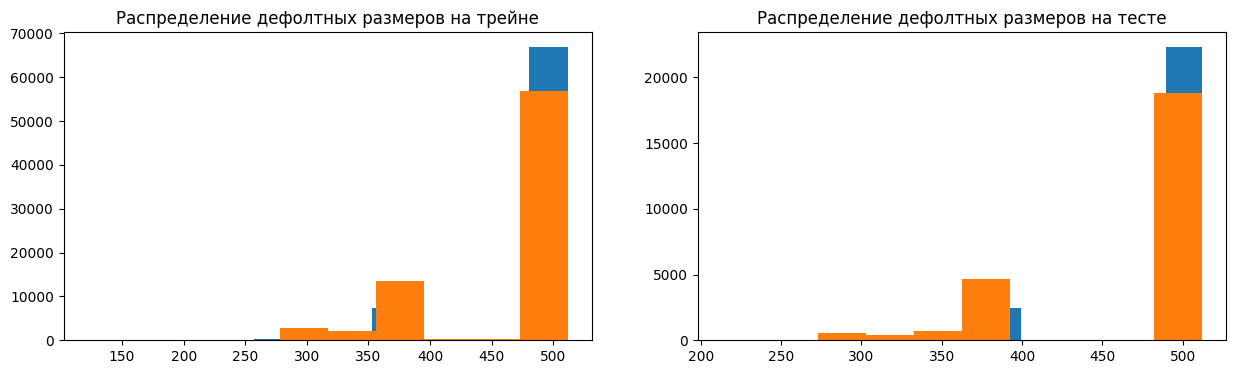

In [286]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))   
axs[0].hist([w for w, h in size_imgs_train])
axs[0].hist([h for w, h in size_imgs_train])
axs[1].hist([w for w, h in size_imgs_test])
axs[1].hist([h for w, h in size_imgs_test])
axs[0].set_title("Распределение дефолтных размеров на трейне")
axs[1].set_title("Распределение дефолтных размеров на тесте")
plt.show()

В архитектуре изображение будем приводить к размеру 512*512, как архитектуру будем использовть EfficientNetB5

##### Примеры картинок

In [18]:
def draw_img_food(label_food: str):
    plt.figure(figsize=(10,5))
    plt.suptitle(f"Примеры картинок для: {label_food}")
    samples_path_images = df_train.query(f"labels=='{label_food}'")['paths'].sample(4)
    for num, path in enumerate(samples_path_images):
        plt.subplot(2,2,num+1)
        img = Image.open(f"images/{path}.jpg")
        plt.axis("off")
        plt.imshow(img)

In [20]:
%%time
#for i in df_train['labels'].unique():
#    draw_img_food(i)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.34 µs


Исходя из просмотров примеров - применим аугментации зеркальное отборожение, Кроп, Контраст. Также можно выделить проблему что блюда представлены в разной фазе приготовления, например, apple_pie - как полностью пирог, как кусочек, и как блюдо смешанное с кремом (желательно дополнительная разметка по состоянию блюда). Еще одна проблема что блюдо может быть на картинке с другой едой, как вариант решения перейти к задаче детекции блюда (TODO). 

##### Пример аугментации

In [29]:
image = cv.imread(f"images/churros/1004234.jpg")
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image = cv.resize(image, (512, 512))

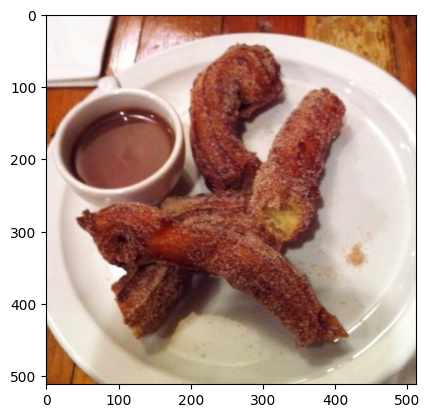

In [30]:
plt.imshow(image)

In [31]:
aug = A.Compose([
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.crops.transforms.RandomResizedCrop(512, 512, scale=(0.85, 0.85), ratio=(1, 1), p=1.0),
])

In [32]:
image = aug(image=image)['image']

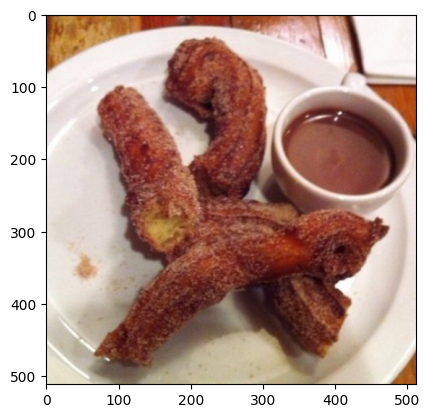

In [33]:
plt.imshow(image)

Цветовое распределение для трейна и теста для каждого класса (TODO) - может помочь понять смещения, например картинки сделаны в разных условиях и т.д.

Посмотреть на метаданные c использованием ExifTags.TAGS (TODO)

In [72]:
df_train.to_csv("meta/train.csv", index=False)

In [73]:
df_test.to_csv("meta/test.csv", index=False)